# Additional stimulation protocols
This notebook shows different ways to apply what was seen in previous examples. The goal is to show how to use it and modifiy it for particular cases.

The examples are:

1. Negative and rheobase step current
2. Multiple negative step current
3. IV-curve resulting from previous example.
4. Multiple positive step current
5. FI-curve resulting from previous example
6. Voltage sag vs distance from soma on multiple dendrites positions
7. A modified EPSP which compared Psp ratio vs distance to soma on multiple dendrites positions

## Compiling mechanisms

In [ ]:
!nrnivmodl ../mechanisms

**Reminder**: The compiled mechanisms need to be provided before importing bluecellulab.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

from pathlib import Path

from matplotlib import pyplot as plt

import neuron
from bluecellulab import Cell
from bluecellulab.simulation import Simulation
from bluecellulab.simulation.neuron_globals import NeuronGlobals
from bluecellulab.tools import search_threshold_current
from bluecellulab.circuit.circuit_access import EmodelProperties


from bluecellulab.stimulus import StimulusFactory

## Loading the cell

In [3]:
# Define the base directory
base_dir = Path("../1-singlecell/")

# Define the hoc and morphology files
hoc_file = base_dir / "hoc" / "cADpyr_L2TPC.hoc"
morph_file = base_dir / "morphology" / "rr110330_C3_idA.asc"

In [4]:
emodel_properties = EmodelProperties(threshold_current=0.03203125,
                                     holding_current=-0.11,
                                     AIS_scaler=1.11)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

Reset function

In [5]:
def reset_cell(hoc_file, morph_file, emodel_properties):
    """ Resets the cell for new stimulation
        Input:
            hoc_file: hoc file path
            morph_file: morphology file path
            emodel_properties: EmodelPropeties
        Output:
            cell: neuron
            sim: Simulation
    """
    cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)
    sim =Simulation()
    sim.add_cell(cell)
    return cell, sim

## Stimulations
### Stimulation function for each protocols
For protocols 1, 5 and 6, the stimulation parameters are based on [Beaulieu-Laroche 2021.](https://www.nature.com/articles/s41586-021-04072-3) to match the experimental protocols for an eventual comparison.

In [6]:
def plot_stim(axs, time, voltage, stim_amp, duration, stim):
    """ Plot stimulation
        Input:
            axs: subplot axes
            time: int in ms
            voltage: voltage response in mV
            stim_amp: float in nA
            duration: int in ms
            stim: StimulusFactory
        Output:
            None
    """
    # Plot voltage over time on the first subplot
    axs[0].plot(time, voltage, marker='.', label=f'{stim_amp}nA', markersize=2)
    axs[0].set_title('Time vs Voltage')
    axs[0].set_xlabel("Time [ms]")
    axs[0].set_ylabel("Voltage [mV]")
    axs[0].set_xlim(left=0)  # Make the plot start from 0 on the x-axis
    # axs[0].legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Plot injected current over time on the second subplot
    axs[1].plot(stim.time, stim.current, label=f'{stim_amp:.3f}nA', drawstyle='steps-post', markersize=2, markeredgewidth=1)
    axs[1].set_title('Time vs Injected Current')
    axs[1].set_xlabel("Time [ms]")
    axs[1].set_ylabel("Injected Current [nA]")
    axs[1].set_xlim(left=0)  # Make the plot start from 0 on the x-axis
    # axs[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')

def step_current_stim(duration, stim_start, stim_delay, stim_amp, hoc_file, morph_file, emodel_properties, segment = 'soma', spike = False):
    """ generate a step current and plot it
        Input:
            duration: int
            stim_start: int in ms
            stim_delay: int in ms
            amp: float in nA
        Output:
            step: StimulusFactory.step
            time: int in ms
            voltage: voltage response in mV
    """
    # reset cell
    cell, sim = reset_cell(hoc_file, morph_file, emodel_properties)
    # set stimulus type, here step
    stim_factory = StimulusFactory(dt=0.1)
    if segment == 'soma':
        cell.start_recording_spikes(None, location='soma', threshold=-10)
    step = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_delay, amplitude=stim_amp)
    if segment != 'soma':
        neuron_section = cell.sections[segment]
        cell.add_voltage_recording(neuron_section, 0.5)
        cell.inject_current_waveform(t_content= step.time, i_content= step.current, section=neuron_section, segx=0.5)
    else:
        neuron_section = cell.soma
        cell.inject_current_waveform(t_content= step.time, i_content= step.current)
    #stimulation
    complete_duration = stim_start + duration + stim_delay
    sim.run(complete_duration, cvode=False)
    print("Done.")

    time = cell.get_time()
    if segment != 'soma':
        voltage = cell.get_voltage_recording(neuron_section, 0.5)
        return step, time, voltage
    else:
        voltage = cell.get_soma_voltage()
        spikes = cell.get_recorded_spikes(location="soma", threshold=-10)
        if spike:
            return step, time, voltage, spikes
        else:
            return step, time, voltage



### 1. Step current injection for rheobase and negative step current 
The rheobase is the minimum current amplitude that triggers an action potential. The negative step current is a protocol that is used to study the adaptation of the cell to a hyperpolarizing current. The stimulation parameters are based on [Beaulieu-Laroche 2021.](https://www.nature.com/articles/s41586-021-04072-3).

In [7]:
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_delay = 100 # delay after stimulation in [ms]
rheobase = search_threshold_current(
        template_name = hoc_file,
        morphology_path = morph_file,
        template_format = "v6",
        emodel_properties = emodel_properties,
        hyp_level = 0,
        inj_start = stim_start,
        inj_stop = stim_start + duration,
        min_current = 0.001,
        max_current = 0.5,
        current_precision = 0.001
    )

Done.
Done.
Done.
Done.


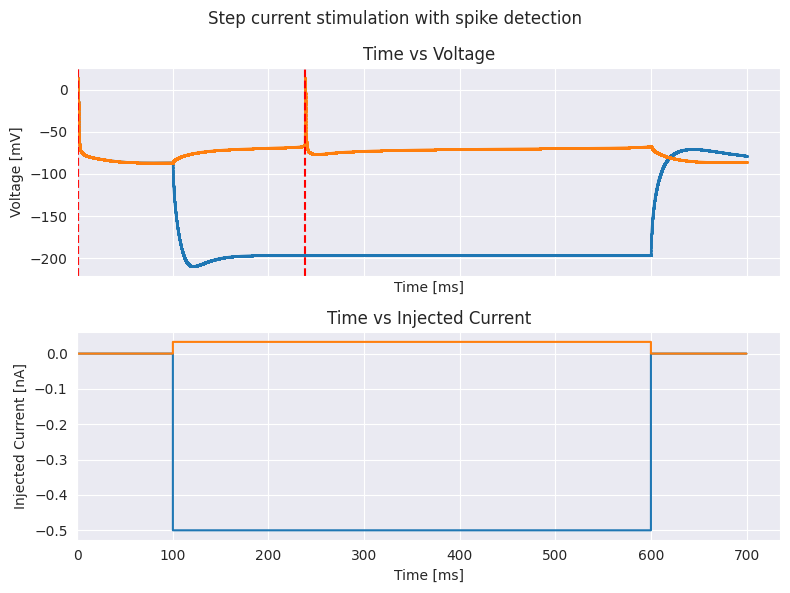

In [8]:
list_amp = [-.5, rheobase] # [nA]
a_section = 5
segment = f'apic[{a_section}]'

steps = []
times = []
times_soma = []
voltages = []
voltages_soma = []
spikes = []
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex = True)  # 2 rows, 1 column, wider figure
fig.suptitle("Step current stimulation with spike detection")
for amp in list_amp:
    step, time_soma, voltage_soma = step_current_stim(duration, stim_start, stim_delay, amp, hoc_file, morph_file, emodel_properties, segment = 'soma', spike=False)
    step, time, voltage, spike = step_current_stim(duration, stim_start, stim_delay, amp, hoc_file, morph_file, emodel_properties, spike=True)
    plot_stim(axs, time_soma, voltage_soma, amp, duration, step)
    # add spikes to the plot as dashed lines
    for spik in spike:
        axs[0].axvline(spik, c="r", linestyle="--")
    spikes.append(spike)
    steps.append(step)
    times.append(time)
    times_soma.append(time_soma)
    voltages.append(voltage)
    voltages_soma.append(voltage_soma)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()

### 2. Multiple negative step current injections
This multiple negative step current injections protocol is used to study the adaptation of the cell to a hyperpolarizing current.

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


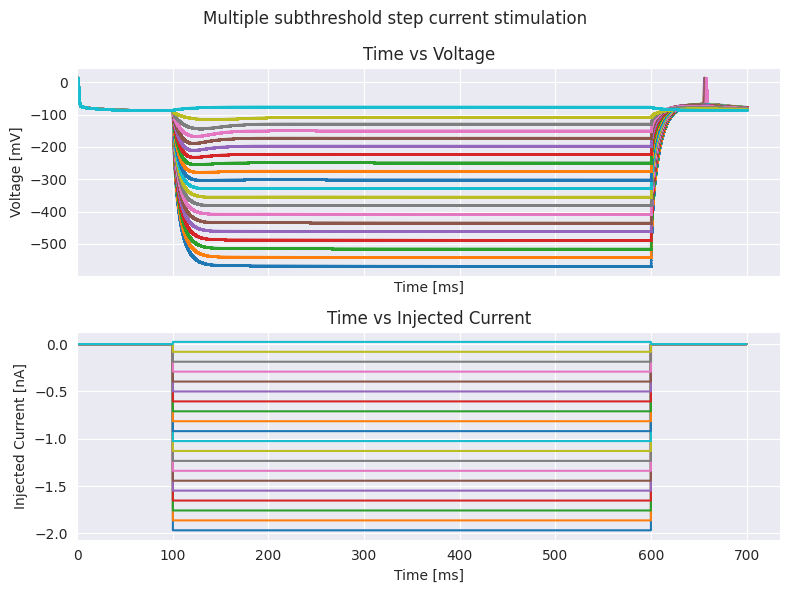

In [9]:
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_delay = 100 # delay after stimulation in [ms]
list_amp = np.linspace(rheobase-2, rheobase-.01, 20) # [nA]

steps = []
times = []
voltages = []
# spikes = []
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex = True)  # 2 rows, 1 column, wider figure
fig.suptitle('Multiple subthreshold step current stimulation')
for amp in list_amp:
    step, time, voltage = step_current_stim(duration, stim_start, stim_delay, amp, hoc_file, morph_file, emodel_properties)
    plot_stim(axs, time, voltage, amp, duration, step)
    # spikes.append(spike)
    steps.append(step)
    times.append(time)
    voltages.append(voltage)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()


### 3. IV Plot
With the previous data obtain in multiple negative step current injections, we can plot the IV curve.

In [10]:
def steady_state_voltage_stimend(stim_start, duration, voltage, t):
    """ steady_state_voltage_stimend
        Calculate the steady state voltage at the end of the stimulation
        Input:
            stim_start: int in ms
            duration: int in ms
            voltage: voltage response in mV
            t: int in ms
        Output:
            steady_state: float in mV
    """
    stim_end = stim_start + duration
    begin_time = stim_end - 0.1 * duration
    end_time = stim_end
    steady_state = np.mean(voltage[np.where((t < end_time) & (t >= begin_time))])
    return steady_state

def plot_IV(stim_start, duration, voltages, times, list_amp):
    """ plot_IV
        Plot the I-V curve
        Input:
            stim_start: int in ms
            duration: int in ms
            voltages: list of voltage responses in mV
            times: list of time in ms
            list_amp: list of injected current in nA
        Output:
            steady_states: list of steady state voltage in mV
    """
    steady_states = []
    for voltage, t in zip(voltages, times):
        steady_state = steady_state_voltage_stimend(stim_start, duration, voltage, t)
        steady_states.append(steady_state)
    sns.set(font_scale=1.5)
    plt.plot(steady_states, list_amp, marker='o')
    plt.title("I-V curve")
    plt.ylabel("Injected current [nA]")
    plt.xlabel("Steady state voltage [mV]")
    plt.tight_layout()
    plt.show()
    return steady_states

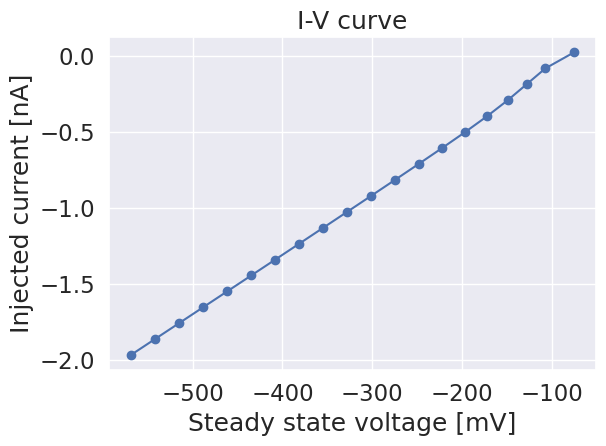

In [11]:
steady_states = plot_IV(stim_start, duration, voltages, times, list_amp)

### 4. Multiple positive step current injections
This multiple positive step current injections protocol is used to study the adaptation of the cell to a depolarizing current.

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


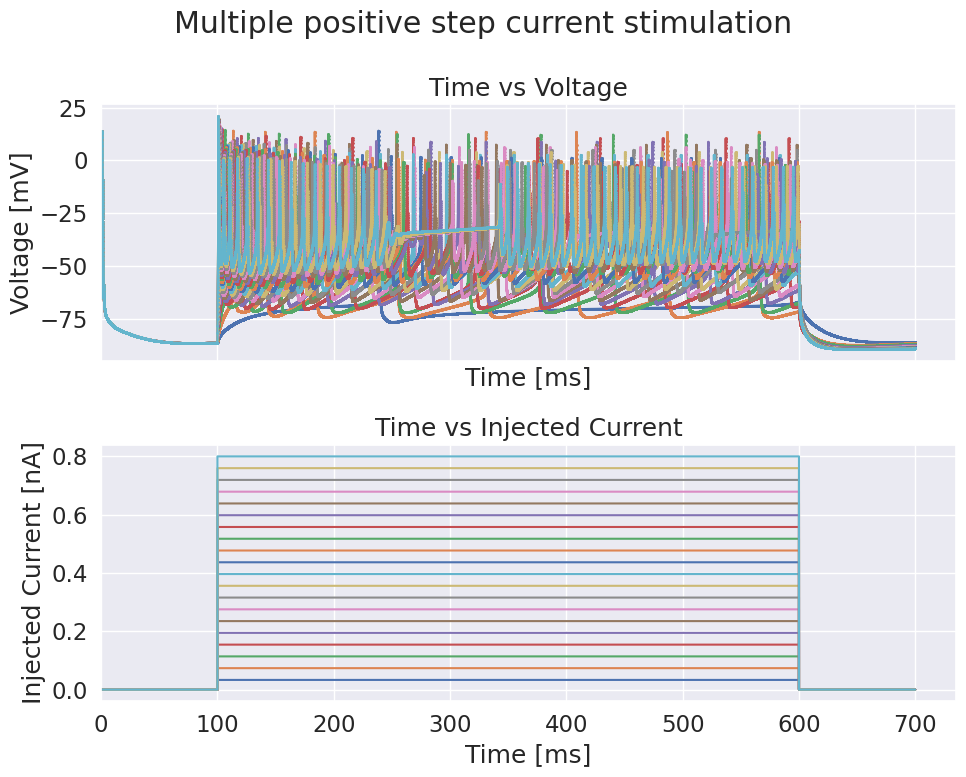

In [12]:
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_end = 100 # delay after stimulation in [ms]
list_amp = np.linspace(rheobase, 0.8, 20)

steps = []
times = []
voltages = []
spikes  = []
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex = True)  # 2 rows, 1 column, wider figure
fig.suptitle('Multiple positive step current stimulation')
for amp in list_amp:
    step, time, voltage, spike = step_current_stim(duration, stim_start, stim_end, amp, hoc_file, morph_file, emodel_properties, segment = 'soma', spike=True)
    plot_stim(axs, time, voltage, amp, duration, step)
    spikes.append(spike)
    steps.append(step)
    times.append(time)
    voltages.append(voltage)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()

### 5. FI curve
With the previous data obtain in multiple positive step current injections, we can plot the FI curve.

In [13]:
def plot_FI(list_amp, spikes):
    """ plot_FI
        Plot the F-I curve
        Input:
            list_amp: list of float
            spikes: list of all spikes for each amplitude
        Output:
            spike_count: list of spike count for each amplitude
    """
    spike_count = [len(spike) for spike in spikes]
    plt.plot(list_amp, spike_count, marker='o')
    plt.title("F-I curve")
    plt.xlabel("Current (nA)")
    plt.ylabel("Spike count")
    plt.tight_layout()
    plt.show()
    return spike_count

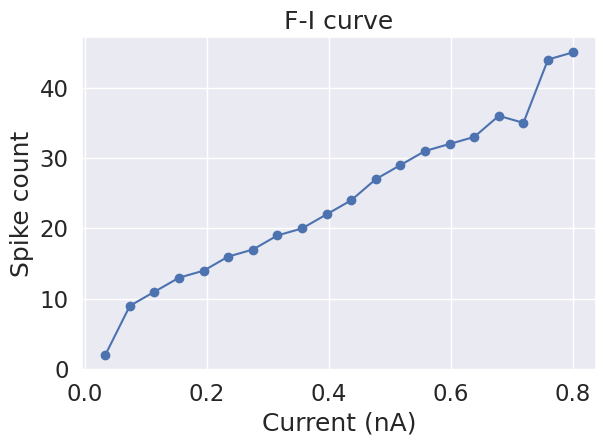

In [14]:
spike_count = plot_FI(list_amp, spikes)

### 6. Voltage Sag accross different distances
This protocol is used to study the voltage sag of the cell at different distances from the soma. The stimulation parameters are based on [Beaulieu-Laroche 2021.](https://www.nature.com/articles/s41586-021-04072-3).

In [15]:
def get_all_distance(all_section, cell):
    """ get_all_distance
        Calculate the distance to soma for all sections
        Input:
            all_section: list of cell.sections
            cell: neuron
        Output:
            all_distance: dictionary
    """
    print('Getting all distances')
    all_distance = {}
    for section in all_section:
        distance_to_soma = neuron.h.distance(cell.soma(0.5), section)
        # store in dictionary: key = section name, value = distance to soma
        all_distance[section] = distance_to_soma
    return all_distance

def sample_elements(dist_dict, min_dist):
    """ sample_elements
        Sample elements from dict
        Input:
            dist_dict: dict
            min_dist: int
        Output:
            sampled_distance: dict
    """
    # sort dictionary by value
    sorted_dict = dict(sorted(dist_dict.items(), key=lambda item: item[1]))
    sampled_distance = {}
    # get first element of all_distance
    first_section = list(sorted_dict.keys())[0]
    sampled_distance[first_section] = sorted_dict[first_section]

    for section, distance in sorted_dict.items():
        if distance - sorted_dict[first_section] > min_dist:
            sampled_distance[section] = distance
            first_section = section

    return sampled_distance

def get_best_sample(all_distance, max_size):
    """ get_best_sample
        Get the best sample
        Input:
            all_distance: dict
            max_size: int
        Output:
            sampled_distance: list
    """
    if len(all_distance) <= max_size:
        return list(all_distance.keys())
    else:
        # using sample_elements function find the min_dist which gives ~max_size with max 50 iterations
        i = 0
        sampled_distance = sample_elements(all_distance, i)

        while len(sampled_distance) > max_size:
            sampled_distance = sample_elements(all_distance, i)
            i += 1
        print(len(sampled_distance))
        print(i)
        # for i in range(0, 500, 1):
        #     sampled_distance = sample_elements(all_distance, i)
        #     if len(sampled_distance) <= max_size:
        #         print(len(sampled_distance))
        #         print(i)
        #         break
        return list(sampled_distance.keys())

The following part is if the cell have too many dendrites or a too skewed morphology. It ables to get a fix number of equidistant stimulation points.

In [16]:
cell, sim = reset_cell(hoc_file, morph_file, emodel_properties)
number_of_sections = 25

all_segments_dend = []
all_segments_apic = []
for section in cell.sections:
    for sec in cell.sections[section]:
        if "dend" in str(sec):
            all_segments_dend.append(sec)
        if "apic" in str(sec):
            all_segments_apic.append(sec)

all_segments = all_segments_dend + all_segments_apic

all_distances_dend = get_all_distance(all_segments_dend, cell)
all_distances_apic = get_all_distance(all_segments_apic, cell)

sampled_all_section_dend = get_best_sample(all_distances_dend, number_of_sections)
sampled_all_section_apic = get_best_sample(all_distances_apic, number_of_sections)

sampled_all_section = sampled_all_section_dend + sampled_all_section_apic
sampled_all_section = [str(sec) for sec in sampled_all_section]

Getting all distances
Getting all distances
25
5
25
12


Let's now apply a negative step current at multiple points of the dendrites.

In [ ]:
# ----------------------- V Sage simulation ------------------------------
duration = 500 # duration for 1 stimulation in [ms]
stim_start = 100 # delay before stimulation in [ms]
stim_end = 100 # delay after stimulation in [ms]
stim_amp = -.5 # [nA]

v_sag_times = []
v_sag_voltages = []
v_sag_voltages_soma = []
all_distance = []
# getting all distances
for section in sampled_all_section:
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    distance_to_soma = neuron.h.distance(cell.soma(0.5), a_section(record_pos))
    all_distance.append(distance_to_soma)
# getting traces and simulating
for section in sampled_all_section:
    cell, sim = reset_cell(hoc_file=hoc_file, morph_file=morph_file, emodel_properties=emodel_properties)
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    cell.add_voltage_recording(a_section, record_pos)
    # set stimulus type, here step
    stim_factory = StimulusFactory(dt=0.1)
    step = stim_factory.step(pre_delay=stim_start, duration= duration, post_delay=stim_end, amplitude=stim_amp)
    cell.inject_current_waveform(t_content = step.time, i_content = step.current, section = a_section, segx = record_pos)
    complete_duration = stim_start + duration + stim_end
    sim.run(complete_duration, cvode=False)
    print("Done.")
    time , voltage, voltage_soma = cell.get_time(), cell.get_voltage_recording(a_section, record_pos), cell.get_soma_voltage()
    v_sag_times.append(time)
    v_sag_voltages.append(voltage)
    v_sag_voltages_soma.append(voltage_soma)
#----------------------- V Sag data in dendrite ------------------------------
v_sags = []
steady_state_voltages = []
peak_currents = []
for voltage, t in zip(v_sag_voltages, v_sag_times):
    steady_state = steady_state_voltage_stimend(stim_start, duration, voltage, t)
    peak_current = min(voltage)
    v_sag = steady_state/ peak_current * 100
    v_sags.append(v_sag)
    steady_state_voltages.append(steady_state)
    peak_currents.append(peak_current)

sampled_all_section = list(map(str, sampled_all_section))
# plot steady state voltage vs time and peak current vs time
df_sag = pd.DataFrame({'Steady state voltage': steady_state_voltages, 'Peak current': peak_currents, 'V sag': v_sags})
df_sag['Distance to soma'] = all_distance
df_sag['Section'] = sampled_all_section

dict_sag = {'time': v_sag_times, 'voltage': v_sag_voltages, 'distance': all_distance, 'section': sampled_all_section}


/tmp/ipykernel_6012/24051413.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_sag, x='Distance to soma', y='V sag', palette='viridis')


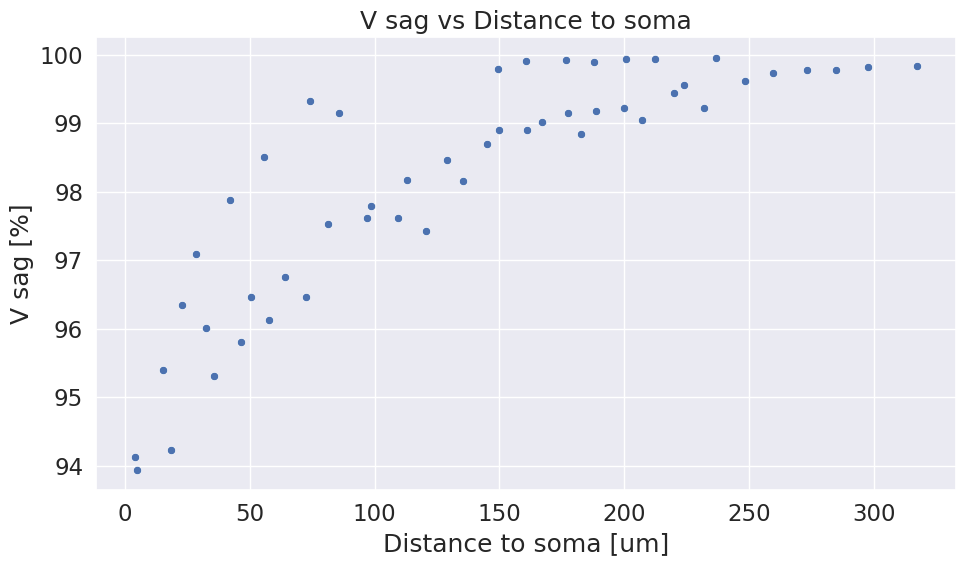

In [18]:
plt.figure(figsize=(10, 6))
plt.title('V sag vs Distance to soma')
sns.scatterplot(data=df_sag, x='Distance to soma', y='V sag', palette='viridis')
plt.xlabel('Distance to soma [um]')
plt.ylabel('V sag [%]')
plt.tight_layout()
plt.show()

### 7. EPSP accross different distances
This protocol is used to study the EPSP of the cell at different distances from the soma. It is an adaptation of example [4-epsp](../4-epsp/).

In [19]:
def EPSP(cell, sim, a_section, record_pos):
    """ EPSP
        Calculate the EPSP ratio by stimulating for 1 section
        Input:
            cell: neuron
            sim: Simulation
            a_section: list of sections
            record_pos: float pos in section
        Output:
            cell: neuron
            sim: Simulation
            current_vector: neuron.h.Vector()
            dendrite_max_epsp_index: int
            soma_max_epsp_index: int
            dendrite_max_epsp: float
            soma_max_epsp: float
            dendrite_psp_amplitude: float in mV
            soma_psp_amplitude: float in mV
            dendrite_voltage_base: float in mV
            soma_voltage_base: float in mV

    """
    # set recording
    cell.add_voltage_recording(a_section, record_pos)

    # synapse and current recording
    onset = 300.0
    tau = 10.0
    gmax = 0.0001
    e = 0.0
    synapse = cell.add_alpha_synapse(onset, tau, gmax, e, section=a_section)

    current_vector = neuron.h.Vector()
    _ = current_vector.record(synapse._ref_i)
    # simulation
    duration = 450
    dt = 0.1
    neuron_globals = NeuronGlobals.get_instance()
    neuron_globals.temperature = 34.0
    neuron_globals.v_init = -70.0
    sim.run(duration, cvode=False, dt=dt)

    voltage = cell.get_voltage_recording(a_section, record_pos)
    soma_voltage = cell.get_soma_voltage()

    voltage_base_offset = 100
    voltage_base_start_index = int(voltage_base_offset / dt)
    protocol_start_index = int(onset / dt)
    protocol_end_index = int((duration) / dt)  # extending till end of simulation

    dendrite_voltage_base = np.median(voltage[voltage_base_start_index:protocol_start_index])
    soma_voltage_base = np.median(soma_voltage[voltage_base_start_index:protocol_start_index])



    dendrite_max_epsp = max(voltage[protocol_start_index:protocol_end_index])
    soma_max_epsp = max(soma_voltage[protocol_start_index:protocol_end_index])
    dendrite_psp_amplitude = dendrite_max_epsp - dendrite_voltage_base
    soma_psp_amplitude = soma_max_epsp - soma_voltage_base

    dendrite_max_epsp_index = np.argmax(voltage[protocol_start_index:protocol_end_index]) + protocol_start_index
    soma_max_epsp_index = np.argmax(soma_voltage[protocol_start_index:protocol_end_index]) + protocol_start_index

    return cell, sim, current_vector, dendrite_max_epsp_index, soma_max_epsp_index, dendrite_max_epsp, soma_max_epsp, dendrite_psp_amplitude, soma_psp_amplitude, dendrite_voltage_base, soma_voltage_base

def EPSP_data(dendrite_psp_amplitude, soma_psp_amplitude, dendrite_max_epsp_index, soma_max_epsp_index, dt):
    """ EPSP_data
        Calculate the EPSP ratio by stimulating for all sections
        Input:
            dendrite_psp_amplitude: float
            soma_psp_amplitude: float
            dendrite_max_epsp_index: int
            soma_max_epsp_index: int
            dt: float
        Output:
            psp ratio: float
            delay: float in ms
    """
    psp_amplitude_ratio = dendrite_psp_amplitude / soma_psp_amplitude
    delay = (soma_max_epsp_index - dendrite_max_epsp_index) * dt

    return psp_amplitude_ratio, delay

The following part is if the cell have too many dendrites or a too skewed morphology. It ables to get a fix number of equidistant stimulation points as it is done in the previous example.

In [20]:
all_segments_dend = []
all_segments_apic = []
for section in cell.sections:
    for sec in cell.sections[section]:
        if "dend" in str(sec):
            all_segments_dend.append(sec)
        if "apic" in str(sec):
            all_segments_apic.append(sec)

all_segments = all_segments_dend + all_segments_apic

all_distances_dend = get_all_distance(all_segments_dend, cell)
all_distances_apic = get_all_distance(all_segments_apic, cell)

sampled_all_section_dend = get_best_sample(all_distances_dend, number_of_sections)
sampled_all_section_apic = get_best_sample(all_distances_apic, number_of_sections)

sampled_all_section = sampled_all_section_dend + sampled_all_section_apic
sampled_all_section = [str(sec) for sec in sampled_all_section]

Getting all distances
Getting all distances
25
5
25
12


We can now apply the epsp protocol at multiple points of the dendrites.

In [ ]:
all_dendrite_max_epsp_index = []
all_soma_max_epsp_index = []
all_dendrite_max_epsp = []
all_soma_max_epsp = []
all_dendrite_psp_amplitude = []
all_soma_psp_amplitude = []
all_dendrite_voltage_base = []
all_soma_voltage_base = []

all_psp_amplitude_ratio = []
all_delay = []
all_time = []
all_voltage = []
all_soma_voltage = []
all_distance = []


for section in sampled_all_section:
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    distance_to_soma = neuron.h.distance(cell.soma(0.5), a_section(record_pos))
    all_distance.append(distance_to_soma)

for section in sampled_all_section:
    cell, sim = reset_cell(hoc_file=hoc_file, morph_file=morph_file, emodel_properties=emodel_properties)
    a_section = cell.sections[section.split('.')[1].split('(')[0]]
    record_pos = float(section.split('(')[1].split(')')[0])
    # gettting values
    cell, sim, current_vector, dendrite_max_epsp_index, soma_max_epsp_index, dendrite_max_epsp, soma_max_epsp, dendrite_psp_amplitude, soma_psp_amplitude, dendrite_voltage_base, soma_voltage_base = EPSP(cell, sim, a_section, record_pos)
    psp_amplitude_ratio, delay = EPSP_data(dendrite_psp_amplitude, soma_psp_amplitude, dendrite_max_epsp_index, soma_max_epsp_index, 0.1)
    time = cell.get_time()
    voltage = cell.get_voltage_recording(a_section, record_pos)
    soma_voltage = cell.get_soma_voltage()

    # append all in corresponding list
    all_dendrite_max_epsp_index.append(dendrite_max_epsp_index)
    all_soma_max_epsp_index.append(soma_max_epsp_index)
    all_dendrite_max_epsp.append(dendrite_max_epsp)
    all_soma_max_epsp.append(soma_max_epsp)
    all_dendrite_psp_amplitude.append(dendrite_psp_amplitude)
    all_soma_psp_amplitude.append(soma_psp_amplitude)
    all_dendrite_voltage_base.append(dendrite_voltage_base)
    all_soma_voltage_base.append(soma_voltage_base)
    all_psp_amplitude_ratio.append(psp_amplitude_ratio)
    all_delay.append(delay)
    all_time.append(time)
    all_voltage.append(voltage)
    all_soma_voltage.append(soma_voltage)



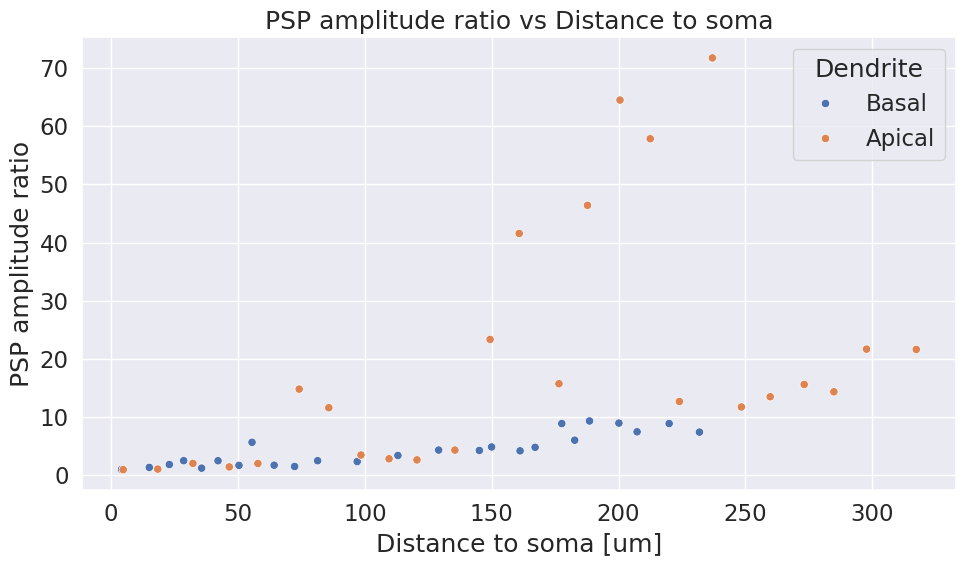

In [22]:
df_epsp = pd.DataFrame({'Dendrite max EPSP index': all_dendrite_max_epsp_index, 'Soma max EPSP index': all_soma_max_epsp_index, 'Dendrite max EPSP': all_dendrite_max_epsp, 'Soma max EPSP': all_soma_max_epsp, 'Dendrite PSP amplitude': all_dendrite_psp_amplitude, 'Soma PSP amplitude': all_soma_psp_amplitude, 'Dendrite voltage base': all_dendrite_voltage_base, 'Soma voltage base': all_soma_voltage_base, 'PSP amplitude ratio': all_psp_amplitude_ratio, 'Delay': all_delay, 'Time': all_time, 'Voltage': all_voltage, 'Soma voltage': all_soma_voltage, 'Distance to soma': all_distance})
df_epsp['Section'] = sampled_all_section
# set true if apical
df_epsp['Dendrite'] = df_epsp['Section'].str.contains('apic')
df_epsp['Dendrite'] = df_epsp['Dendrite'].apply(lambda x: 'Apical' if x == True else 'Basal')

plt.figure(figsize=(10, 6))
plt.title('PSP amplitude ratio vs Distance to soma')
sns.scatterplot(data=df_epsp, x='Distance to soma', y='PSP amplitude ratio', hue = 'Dendrite')
plt.xlabel('Distance to soma [um]')
plt.ylabel('PSP amplitude ratio')
plt.tight_layout()
plt.show()